In [39]:
import json
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Markdown
from PIL import Image

from stackexp import openai_util
from stackexp.export_comments import OUTPUT_PATH as COMMENT__PATH, load_comments_json, TAGS_PATH as COMMENT_TAGS_PATH
from stackexp.nb_config import nb_config
from stackexp.openai_util import PROMPT_CACHE
from stackexp.util import DATA_DIR

SELECTED_TAGS_PATH = DATA_DIR / 'substack_tags_select.csv'

nb_config()
embedding_cache = openai_util.EmbeddingCache()

CHAT_COMPLETE_MODEL = "gpt-4o"
EMBEDDING_MODEL = 'text-embedding-3-small'

In [2]:
comments_json = load_comments_json(COMMENT__PATH)
print(len(comments_json))
comments_json[-1]

1186


{'post_id': 158988051,
 'title': "The stock market won't save us",
 'canonical_url': 'https://www.slowboring.com/p/the-stock-market-wont-save-us',
 'name': 'Matt Hagy',
 'user_id': 3094604,
 'reaction': False,
 'id': 101506720,
 'top_level': False,
 'date': 'Mar 18 2025 14:44',
 'likes': 4,
 'timestamp': 1742323491,
 'body': [[{'type': 'text',
    'value': 'Ah, would just be another one to add to the list, '},
   {'type': 'url',
    'value': 'https://en.wikipedia.org/wiki/List_of_lawsuits_involving_Tesla,_Inc'},
   {'type': 'text', 'value': '.'}],
  [{'type': 'text',
    'value': "> This is a partial list of lawsuits involving Tesla, Inc, the American automotive and energy company, since 2008; as of August 2023, Tesla is party to over 1,750 lawsuits, and as of September 2021, it is party to 200 in China alone. A significant number of the cases notably derive from the actions of the company's CEO, Elon Musk, who is also party to many of his own lawsuits. TSLAQ, a loose collective of ano

In [3]:
def construct_comment(paragraphs: list[list[dict[str, Any]]]) -> str:
    return '\n\n'.join(' '.join(l['value'] for l in p if l['type'] == 'text')
                       for p in paragraphs)


comments = pd.DataFrame(comments_json)
comments = comments.set_index('id')
comments['body'] = comments['body'].map(construct_comment)
comments['word_count'] = comments['body'].map(openai_util.count_words)
comments['token_count'] = comments['body'].map(openai_util.count_tokens)
comments

,post_id,title,canonical_url,name,user_id,reaction,top_level,date,likes,timestamp,...,parent_children,thread_id,thread_children,ratio_recv,ratio_give,grade_level,word_count,category,tags,token_count
id,,,,,,,,,,,,,,,,,,,,,
3305267,42751863,Dave Chappelle and the still-doomed politics o...,https://www.slowboring.com/p/dave-chappelle-an...,Matt Hagy,3094604,False,False,Oct 20 2021 13:28,8,1634750923,...,18.0,3301076,18,-6.0,-3.0,10.3,188,"Diverse Discussions on Technology, Responsibil...","[business strategy, censorship, media influenc...",240
3487721,43514326,Thoughts on the Virginia election,https://www.noahpinion.blog/p/thoughts-on-the-...,Matt Hagy,3094604,False,False,Nov 04 2021 07:40,1,1636026050,...,3.0,3485207,3,NaN,-12.0,10.7,208,Navigating Political Strategy and Media Influe...,"[Democratic Party, economic inequality, identi...",254
3592608,43776715,European countries have really high taxes,https://www.slowboring.com/p/european-countrie...,Matt Hagy,3094604,False,False,Nov 12 2021 07:32,17,1636720370,...,16.0,3592377,16,-15.0,5.0,5.0,73,Analyzing Political Preferences and Policy Deb...,"[economic policy, taxation]",115
3644093,43937960,Time to declare victory on stimulating the eco...,https://www.slowboring.com/p/time-to-declare-v...,Matt Hagy,3094604,False,False,Nov 16 2021 15:24,0,1637094259,...,5.0,3642299,5,0.0,-3.0,8.9,249,Uncategorized,[],340
3901854,44832459,What is the goal of child care policy?,https://www.slowboring.com/p/what-is-the-goal-...,Matt Hagy,3094604,False,False,Dec 07 2021 05:28,0,1638872898,...,4.0,3891603,6,NaN,-2.0,10.7,134,Uncategorized,[],166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101409011,158988051,The stock market won't save us,https://www.slowboring.com/p/the-stock-market-...,Matt Hagy,3094604,False,False,Mar 18 2025 08:17,1,1742300232,...,11.0,101391959,114,4.0,-6.0,10.2,123,Uncategorized,[],167
101415744,158988051,The stock market won't save us,https://www.slowboring.com/p/the-stock-market-...,Matt Hagy,3094604,False,False,Mar 18 2025 08:51,1,1742302289,...,3.0,101391959,114,3.0,-1.0,10.1,164,Uncategorized,[],194
101420945,158988051,The stock market won't save us,https://www.slowboring.com/p/the-stock-market-...,Matt Hagy,3094604,False,False,Mar 18 2025 09:15,13,1742303704,...,10.0,101391959,114,-2.0,-8.0,11.4,72,Uncategorized,[],91


In [4]:
best_comments = (
    comments[
        (comments['token_count'].between(40, 2000))
    ].sort_values('likes', ascending=False)
)
best_comments[['likes', 'word_count', 'token_count', 'body']]

,likes,word_count,token_count,body
id,,,,
10926838,117,108,158,It is noteworthy that all of these effective D...
15195301,102,137,170,I can’t help feeling that a lot of the anti-SA...
10138366,101,434,537,"> I’m not exactly sure why this happened, but ..."
13140414,95,181,214,> But this whole genre of genuine inquiry into...
12967487,93,49,59,Then argue for higher speed limits while conti...
...,...,...,...,...
11191775,0,222,287,Angelo Mozilo was investigated by the federal ...
95542513,0,206,278,"Just buy an Android. It’s a solid platform, an..."
47810380,0,59,76,ChatGPT can natively do a decent job summarizi...


In [5]:
substack_tags_select = pd.read_csv(SELECTED_TAGS_PATH)
substack_tags_select

,tag,count,in_refined,choose
0,media influence,738.0,True,True
1,public misinformation,608.0,True,True
2,political polarization,468.0,True,True
3,political leadership,420.0,True,True
4,political campaigns,290.0,True,True
...,...,...,...,...
191,tribalism,1.0,False,False
192,violence,1.0,False,False
193,voter ID issues,1.0,False,False
194,warfare tactics,1.0,False,False


In [6]:
selected_tags = substack_tags_select[substack_tags_select['choose']]['tag'].tolist()
print(len(selected_tags))
selected_tags

64


['media influence',
 'public misinformation',
 'political polarization',
 'political leadership',
 'political campaigns',
 'trust in institutions',
 'social justice',
 'economic inequality',
 'censorship',
 'international relations',
 'education inequality',
 'urban development',
 'free speech issues',
 'gender equality',
 'mental health',
 'housing affordability',
 'immigration issues',
 'labor unions',
 'healthcare complexity',
 'digital privacy',
 'authoritarianism',
 'public safety',
 'environmental impact',
 'climate change',
 'criminal justice reform',
 'human rights',
 'voter behavior',
 'corporate accountability',
 'drug policy',
 'economic policy',
 'AI and ethics',
 'US politics',
 'activism',
 'crime and justice',
 'electoral integrity',
 'foreign policy',
 'geopolitical strategy',
 'hate speech',
 'pandemic response',
 'privacy issues',
 'public health',
 'racial equality',
 'racial policy',
 'religious freedom',
 'renewable energy',
 'social media influence',
 'technology 

In [53]:
selected_tags_comments = []
for i, (_, comment) in enumerate(best_comments.iterrows()):
    print(f'comment {i}')
    tag_comment_response = PROMPT_CACHE.get_or_create(
        prompt_rel_path=Path('tag_comment/v0.txt'),
        cache_key=f'comment_{comment.name}',
        template_values=dict(tags=json.dumps(selected_tags), comment=comment['body']),
        run_prompt_kwds=dict(response_format={"type": "json_object"}),
        cache_suffix='json'
    )
    tag_comment = json.loads(tag_comment_response)
    tag_comment['id'] = comment.name
    selected_tags_comments.append(tag_comment)
selected_tags_comments = pd.DataFrame(selected_tags_comments).set_index('id')
selected_tags_comments

comment 0
comment 1
comment 2
comment 3
comment 4
comment 5
comment 6
comment 7
comment 8
comment 9
comment 10
comment 11
comment 12
comment 13
comment 14
comment 15
comment 16
comment 17
comment 18
comment 19
comment 20
comment 21
comment 22
comment 23
comment 24
comment 25
comment 26
comment 27
comment 28
comment 29
comment 30
comment 31
comment 32
comment 33
comment 34
comment 35
comment 36
comment 37
comment 38
comment 39
comment 40
comment 41
comment 42
comment 43
comment 44
comment 45
comment 46
comment 47
comment 48
comment 49
comment 50
comment 51
comment 52
comment 53
comment 54
comment 55
comment 56
comment 57
comment 58
comment 59
comment 60
comment 61
comment 62
comment 63
comment 64
comment 65
comment 66
comment 67
comment 68
comment 69
comment 70
comment 71
comment 72
comment 73
comment 74
comment 75
comment 76
comment 77
comment 78
comment 79
comment 80
comment 81
comment 82
comment 83
comment 84
comment 85
comment 86
comment 87
comment 88
comment 89
comment 90
comment 9

,tags,residual_tags
id,,
10926838,"[political campaigns, voter behavior, public m...","[messaging strategy, popularism, political com..."
15195301,"[education inequality, economic inequality, so...","[standardized testing, college admissions, edu..."
10138366,"[economic policy, technology ethics, labor uni...","[Silicon Valley trends, tech industry dynamics..."
13140414,"[public misinformation, political polarization...","[political compromise, public opinion, plurali..."
12967487,"[political leadership, trust in institutions, ...","[law and order, civic responsibility, governme..."
...,...,...
11191775,"[corporate accountability, crime and justice, ...","[subprime mortgage crisis, securities fraud, i..."
95542513,"[digital privacy, media influence, technology ...","[smartphone user choice, app store policies, s..."
47810380,"[media influence, political campaigns, public ...","[AI applications, election 2024, political sat..."


In [54]:
selected_apply_tag_counts = pd.Series([
    tag
    for tags in selected_tags_comments['tags']
    for tag in tags
]).value_counts()
selected_apply_tag_counts

media influence              357
economic policy              329
US politics                  245
political polarization       195
political leadership         178
                            ... 
unionization                   1
public employment              1
government accountability      1
automation                     1
online discourse               1
Name: count, Length: 190, dtype: int64

<Axes: >

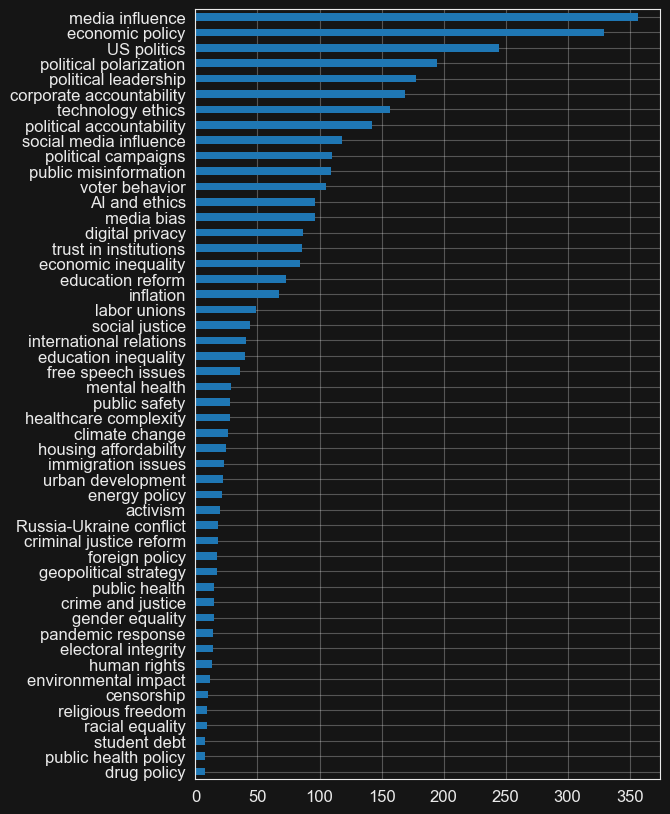

In [55]:
selected_apply_tag_counts.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

In [56]:
residual_apply_tag_counts = pd.Series([
    tag
    for tags in selected_tags_comments['residual_tags']
    for tag in tags
]).value_counts()
residual_apply_tag_counts

Elon Musk                 27
tax policy                25
fiscal policy             23
monetary policy           20
financial regulation      15
                          ..
data interpretation        1
sentiment analysis         1
media scrutiny             1
journalistic standards     1
lobbying influence         1
Name: count, Length: 2196, dtype: int64

<Axes: >

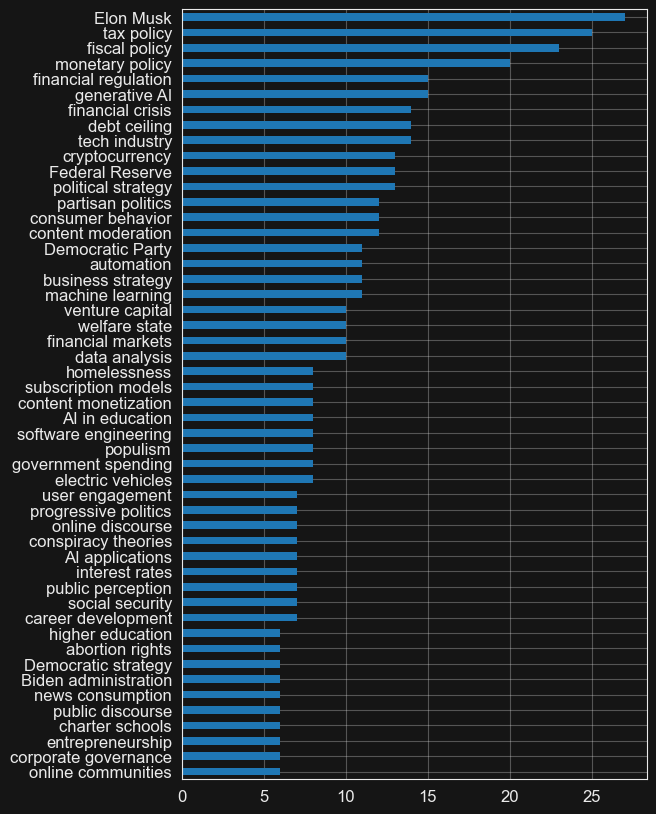

In [57]:
residual_apply_tag_counts.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

In [58]:
all_tags_count = selected_apply_tag_counts.add(residual_apply_tag_counts, fill_value=0).astype(int).sort_values(
    ascending=False)
all_tags_count

media influence           357
economic policy           333
US politics               247
political polarization    195
political leadership      179
                         ... 
employment prospects        1
employment programs         1
employment benefits         1
employment                  1
zoning regulations          1
Name: count, Length: 2319, dtype: int64

<Axes: >

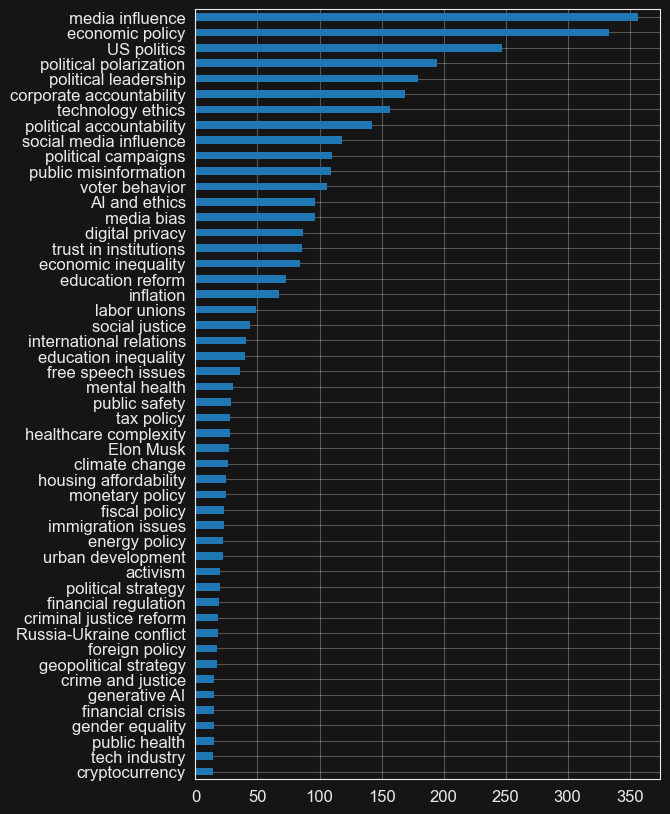

In [59]:
all_tags_count.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

In [60]:
selected_tags_comments_aug = pd.DataFrame([
    dict(id=i, tag=tag)
    for i, tags in selected_tags_comments['tags'].items()
    for tag in tags
])
selected_tags_comments_aug = pd.merge(
    selected_tags_comments_aug,
    comments,
    left_on='id',
    right_index=True,
    how='left'
)
selected_tags_comments_aug

,id,tag,post_id,title,canonical_url,name,user_id,reaction,top_level,date,...,parent_children,thread_id,thread_children,ratio_recv,ratio_give,grade_level,word_count,category,tags,token_count
0,10926838,political campaigns,88097777,A lot of the best political messages are reall...,https://www.slowboring.com/p/a-lot-of-the-best...,Matt Hagy,3094604,False,True,Dec 05 2022 06:29,...,NaN,10926838,19,-94.0,NaN,12.7,108,Navigating Political Polarization and Activism,"[Democratic Party, identity politics, populism]",158
1,10926838,voter behavior,88097777,A lot of the best political messages are reall...,https://www.slowboring.com/p/a-lot-of-the-best...,Matt Hagy,3094604,False,True,Dec 05 2022 06:29,...,NaN,10926838,19,-94.0,NaN,12.7,108,Navigating Political Polarization and Activism,"[Democratic Party, identity politics, populism]",158
2,10926838,public misinformation,88097777,A lot of the best political messages are reall...,https://www.slowboring.com/p/a-lot-of-the-best...,Matt Hagy,3094604,False,True,Dec 05 2022 06:29,...,NaN,10926838,19,-94.0,NaN,12.7,108,Navigating Political Polarization and Activism,"[Democratic Party, identity politics, populism]",158
3,10926838,media influence,88097777,A lot of the best political messages are reall...,https://www.slowboring.com/p/a-lot-of-the-best...,Matt Hagy,3094604,False,True,Dec 05 2022 06:29,...,NaN,10926838,19,-94.0,NaN,12.7,108,Navigating Political Polarization and Activism,"[Democratic Party, identity politics, populism]",158
4,15195301,education inequality,115956601,There's no big mystery about why colleges are ...,https://www.slowboring.com/p/sat-optional-affi...,Matt Hagy,3094604,False,True,Apr 25 2023 06:37,...,NaN,15195301,324,-84.0,NaN,14.5,137,Evaluating the Role and Impact of Elite Education,"[crime and justice, education inequality, high...",170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3665,11157661,political leadership,89799685,Elon Musk is the latest victim of the online r...,https://www.slowboring.com/p/elon-musk-is-the-...,Matt Hagy,3094604,False,False,Dec 14 2022 18:16,...,6.0,11141666,60,1.0,0.0,8.0,274,Uncategorized,[],369
3666,11157661,public misinformation,89799685,Elon Musk is the latest victim of the online r...,https://www.slowboring.com/p/elon-musk-is-the-...,Matt Hagy,3094604,False,False,Dec 14 2022 18:16,...,6.0,11141666,60,1.0,0.0,8.0,274,Uncategorized,[],369
3667,6908518,education inequality,57340427,Two cheers for American higher education,https://www.slowboring.com/p/two-cheers-for-am...,Matt Hagy,3094604,False,False,Jun 02 2022 13:48,...,2.0,6900138,6,NaN,-2.0,10.2,60,Uncategorized,[],87
3668,6908518,political leadership,57340427,Two cheers for American higher education,https://www.slowboring.com/p/two-cheers-for-am...,Matt Hagy,3094604,False,False,Jun 02 2022 13:48,...,2.0,6900138,6,NaN,-2.0,10.2,60,Uncategorized,[],87


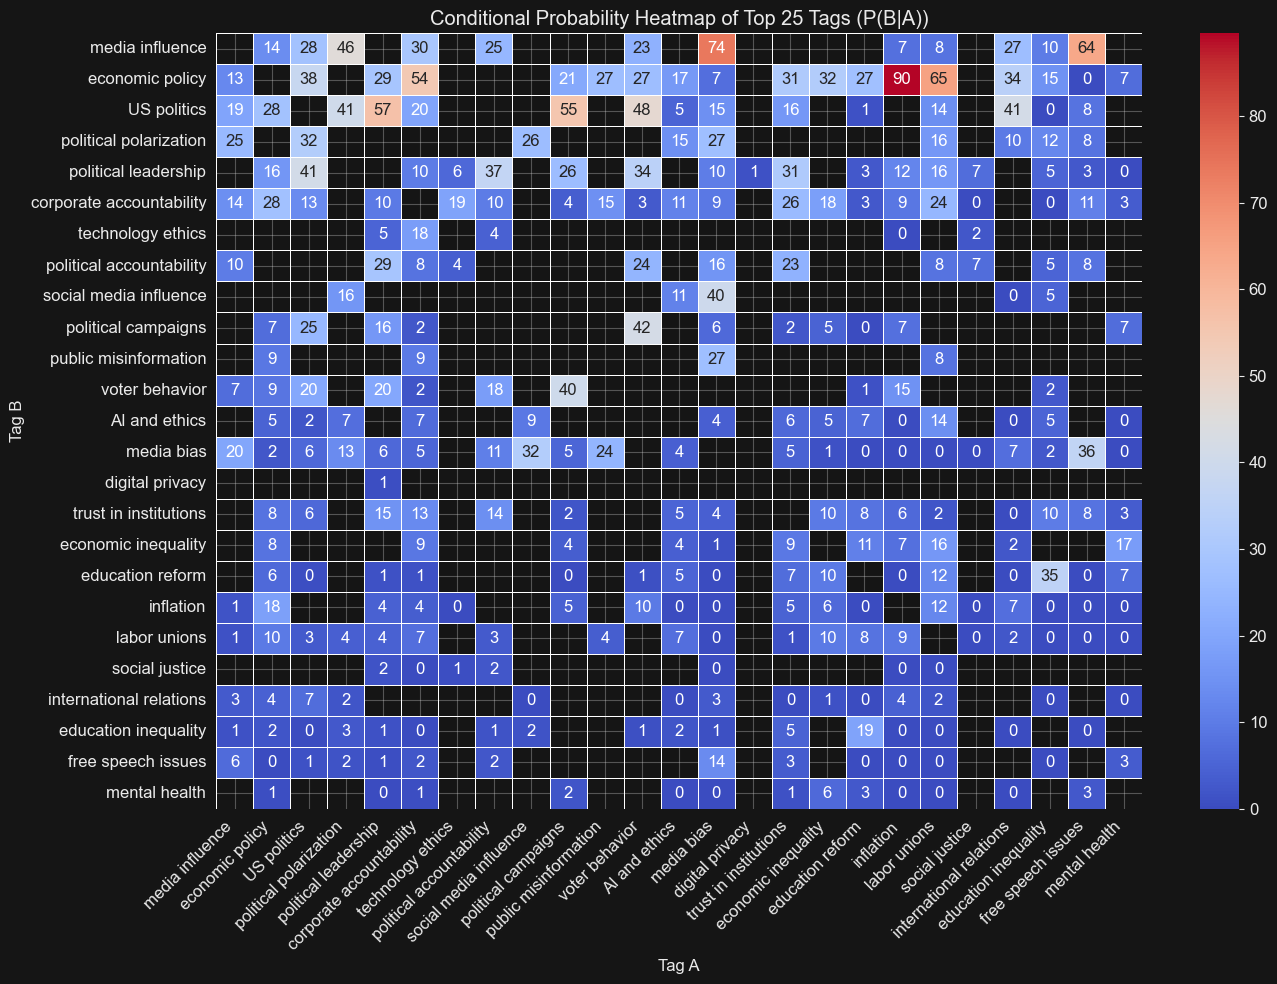

In [61]:
# Step 1: Get the top 25 most frequent tags
top_tags = selected_tags_comments_aug['tag'].value_counts().nlargest(25).index

# Step 2: Filter the dataframe for only the top tags
df_top_tags = selected_tags_comments_aug[selected_tags_comments_aug['tag'].isin(top_tags)]

# Step 3: Create a tag co-occurrence matrix
# Pivot the data to create a binary matrix for tags per id
tag_matrix = df_top_tags.pivot_table(index='id', columns='tag', aggfunc='size', fill_value=0)

# Step 4: Calculate the conditional probability matrix
# Compute the conditional probability P(B|A) where A is on the X-axis and B is on the Y-axis
tag_counts = tag_matrix.T.dot(tag_matrix)
conditional_prob_matrix = tag_counts / tag_matrix.sum(axis=0)

# Step 5: Order tags by frequency
conditional_prob_matrix = conditional_prob_matrix.loc[top_tags, top_tags]

# Step 6: Create a mask to hide the diagonal
mask = np.eye(conditional_prob_matrix.shape[0], dtype=bool) | (tag_counts < 5)

# Step 7: Create a heatmap to visualize the conditional probabilities
plt.figure(figsize=(14, 10))
sns.heatmap(conditional_prob_matrix * 100, annot=True, fmt='.0f', cmap='coolwarm', linewidths=0.5, mask=mask)
plt.title('Conditional Probability Heatmap of Top 25 Tags (P(B|A))')
plt.xlabel('Tag A')
plt.ylabel('Tag B')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Display the heatmap
plt.show()


In [62]:
tag_counts

tag,AI and ethics,US politics,corporate accountability,digital privacy,economic inequality,economic policy,education inequality,education reform,free speech issues,inflation,...,political accountability,political campaigns,political leadership,political polarization,public misinformation,social justice,social media influence,technology ethics,trust in institutions,voter behavior
tag,,,,,,,,,,,,,,,,,,,,,
AI and ethics,96,5,11,18,4,16,2,5,0,0,...,3,3,4,14,5,0,11,62,5,1
US politics,5,245,33,0,9,93,0,1,3,25,...,71,61,101,79,24,0,8,10,14,50
corporate accountability,11,33,169,20,15,92,0,2,4,6,...,14,4,17,4,16,0,7,30,22,3
digital privacy,18,0,20,87,1,4,1,3,7,0,...,0,2,1,2,5,0,19,45,5,0
economic inequality,4,9,15,1,84,27,12,8,0,5,...,7,4,9,9,7,15,4,5,8,5
economic policy,16,93,92,4,27,329,6,20,0,60,...,40,23,52,33,29,6,4,24,27,28
education inequality,2,0,0,1,12,6,40,14,0,0,...,2,1,2,5,3,9,2,3,4,1
education reform,5,1,2,3,8,20,14,73,0,0,...,11,0,2,4,8,6,3,15,6,1
free speech issues,0,3,4,7,0,0,0,0,36,0,...,3,1,1,3,4,0,9,5,3,0


In [63]:
tag_matrix.sum(axis=0)

tag
AI and ethics                96
US politics                 245
corporate accountability    169
digital privacy              87
economic inequality          84
economic policy             329
education inequality         40
education reform             73
free speech issues           36
inflation                    67
international relations      41
labor unions                 49
media bias                   96
media influence             357
mental health                29
political accountability    142
political campaigns         110
political leadership        178
political polarization      195
public misinformation       109
social justice               44
social media influence      118
technology ethics           157
trust in institutions        86
voter behavior              105
dtype: int64

In [49]:
with COMMENT_TAGS_PATH.open('w') as f:
    json.dump(dict(selected_tags_comments['tags'].sort_index().items()), f, indent=2)

In [89]:
tags_to_define = sorted(all_tags_count.head(200).index)
tags_to_define

['AI advancements',
 'AI and ethics',
 'AI applications',
 'AI in education',
 'AI regulation',
 'Biden administration',
 'Democratic Party',
 'Democratic strategy',
 'Elon Musk',
 'Federal Reserve',
 'Russia-Ukraine conflict',
 'Trump',
 'Trump administration',
 'US economy',
 'US politics',
 'US-China relations',
 'abortion debate',
 'abortion rights',
 'activism',
 'advertising revenue',
 'algorithmic curation',
 'antisemitism',
 'antitrust issues',
 'atheism',
 'authoritarianism',
 'automation',
 'bank regulation',
 'banking crisis',
 'banking industry',
 'banking regulation',
 'belief systems',
 'billionaire influence',
 'bipartisanship',
 'bond market',
 'bureaucracy',
 'business innovation',
 'business strategy',
 'capitalism',
 'career development',
 'career transitions',
 'censorship',
 'central banking',
 'charter schools',
 'class dynamics',
 'climate change',
 'coalition dynamics',
 'comment analysis',
 'community engagement',
 'conflict resolution',
 'conspiracy theories',

In [90]:
tags_define_response = PROMPT_CACHE.get_or_create(
    prompt_rel_path=Path('tag_define/v0.txt'),
    cache_key=f'tags_to_define',
    template_values=dict(tags=json.dumps(tags_to_define)),
    run_prompt_kwds=dict(response_format={"type": "json_object"}),
    cache_suffix='json'
)
tag_definitions = pd.DataFrame(json.loads(tags_define_response.strip())['tag_definitions'])
assert set(tag_definitions.columns) == {'tag', 'definition'}, f'columns: {tag_definitions.columns}'
tag_definitions

{"tag_definitions":
    [
        {
            "tag": "AI advancements",
            "definition": "Progress and innovations in artificial intelligence technologies and capabilities."
        },
        {
            "tag": "AI and ethics",
            "definition": "Consideration of moral principles and dilemmas arising from the use of artificial intelligence."
        },
        {
            "tag": "AI applications",
            "definition": "The various uses and implementations of artificial intelligence across different sectors."
        },
        {
            "tag": "AI in education",
            "definition": "The integration and impact of artificial intelligence technologies in educational settings."
        },
        {
            "tag": "AI regulation

KeyboardInterrupt: 

In [91]:
(pd.concat([
    all_tags_count.rename('count'),
    tag_definitions.set_index('tag')['definition'],
], axis=1)
 .sort_values('count', ascending=False)
 .to_clipboard(index=True))

In [64]:
selected_defined_tags = pd.read_csv(DATA_DIR / 'Hagy Comment Tag Definitions - 2025-01-01 - Sheet1.csv')
selected_defined_tags = selected_defined_tags[selected_defined_tags['select']].drop(['select'], axis=1)
selected_defined_tags

,tag,count,definition
0,economic policy,284,A course of action taken by a government to in...
1,media influence,255,The impact that media has on shaping public op...
2,US politics,175,"The political activities, events, and policies..."
3,political polarization,156,The process by which political attitudes diver...
8,social media influence,89,The impact that social media platforms and per...
...,...,...,...
173,advertising revenue,3,Income generated from the promotion of product...
175,historical analysis,3,The examination of past events to understand t...
179,right-wing politics,3,Political ideologies and movements that emphas...
181,gun rights,3,The belief in and advocacy for the legal right...


In [65]:
# selected_defined_tags.to_clipboard(index=False)

In [66]:
tag_definitions = selected_defined_tags[['tag', 'definition']].sort_values('tag').reset_index(drop=True)
tag_definitions

,tag,definition
0,Biden administration,The executive branch of the U.S. government un...
1,Democratic Party,One of the two major political parties in the ...
2,Federal Reserve,The central banking system of the United State...
3,Russia-Ukraine conflict,The ongoing geopolitical and military tensions...
4,US politics,"The political activities, events, and policies..."
...,...,...
72,tax policy,Governmental guidelines that dictate how taxes...
73,taxation,The system through which a government raises r...
74,tech industry,"The sector focused on research, development, a..."
75,trust in institutions,The public's confidence in the reliability and...


In [67]:
print(tag_definitions.to_json(orient='records', index=False))

[{"tag":"Biden administration","definition":"The executive branch of the U.S. government under President Joe Biden."},{"tag":"Democratic Party","definition":"One of the two major political parties in the United States, generally associated with liberal policies."},{"tag":"Federal Reserve","definition":"The central banking system of the United States responsible for monetary policy."},{"tag":"Russia-Ukraine conflict","definition":"The ongoing geopolitical and military tensions between Russia and Ukraine."},{"tag":"US politics","definition":"The political activities, events, and policies related to the governance of the United States."},{"tag":"abortion rights","definition":"The belief in or advocacy for the legal right to access abortion services."},{"tag":"activism","definition":"Efforts and actions aimed at promoting, impeding, or directing social, political, or environmental change."},{"tag":"advertising revenue","definition":"Income generated from the promotion of products or servic

In [68]:
defined_tags_comments = []
for i, (_, comment) in enumerate(best_comments.iterrows()):
    print(f'comment {i}')
    tag_comment_response = PROMPT_CACHE.get_or_create(
        prompt_rel_path=Path('tag_comment_defined/v0.txt'),
        cache_key=f'comment_{comment.name}',
        template_values=dict(tag_definitions=tag_definitions.to_json(orient='records', index=False),
                             comment=comment['body']),
        run_prompt_kwds=dict(response_format={"type": "json_object"}),
        cache_suffix='json'
    )
    tag_comment = json.loads(tag_comment_response)
    assert set(tag_comment.keys()) == {'tags'}, f'keys: {tag_comment.keys()}'
    tag_comment['id'] = comment.name
    defined_tags_comments.append(tag_comment)
defined_tags_comments = pd.DataFrame(defined_tags_comments).set_index('id')
defined_tags_comments

comment 0
comment 1
comment 2
comment 3
comment 4
comment 5
comment 6
comment 7
comment 8
comment 9
comment 10
comment 11
comment 12
comment 13
comment 14
comment 15
comment 16
comment 17
comment 18
comment 19
comment 20
comment 21
comment 22
comment 23
comment 24
comment 25
comment 26
comment 27
comment 28
comment 29
comment 30
comment 31
comment 32
comment 33
comment 34
comment 35
comment 36
comment 37
comment 38
comment 39
comment 40
comment 41
comment 42
comment 43
comment 44
comment 45
comment 46
comment 47
comment 48
comment 49
comment 50
comment 51
comment 52
comment 53
comment 54
comment 55
comment 56
comment 57
comment 58
comment 59
comment 60
comment 61
comment 62
comment 63
comment 64
comment 65
comment 66
comment 67
comment 68
comment 69
comment 70
comment 71
comment 72
comment 73
comment 74
comment 75
comment 76
comment 77
comment 78
comment 79
comment 80
comment 81
comment 82
comment 83
comment 84
comment 85
comment 86
comment 87
comment 88
comment 89
comment 90
comment 9

,tags
id,
10926838,"[Democratic Party, populism, identity politics]"
15195301,"[education inequality, crime and justice, high..."
10138366,"[tech industry, labor market, business strateg..."
13140414,"[media influence, public misinformation, polit..."
12967487,"[taxation, law and order]"
...,...
11191775,"[crime and justice, financial regulation, fina..."
95542513,"[consumer behavior, tech industry, trust in in..."
47810380,"[US politics, political campaigns, immigration..."


In [69]:
defined_tag_counts = pd.Series([
    tag
    for tags in defined_tags_comments['tags']
    for tag in tags
]).value_counts()
defined_tag_counts

US politics                  271
media influence              174
economic policy              167
tech industry                160
partisan politics            148
                            ... 
moral philosophy               1
externalities                  1
personal autonomy              1
government accountability      1
economic sentiment             1
Name: count, Length: 191, dtype: int64

<Axes: >

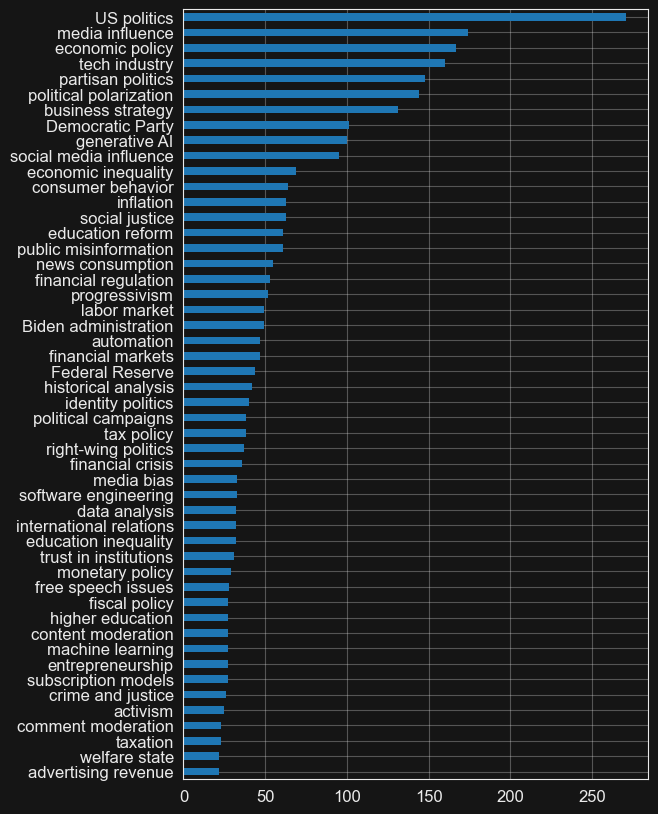

In [70]:
defined_tag_counts.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

<Axes: >

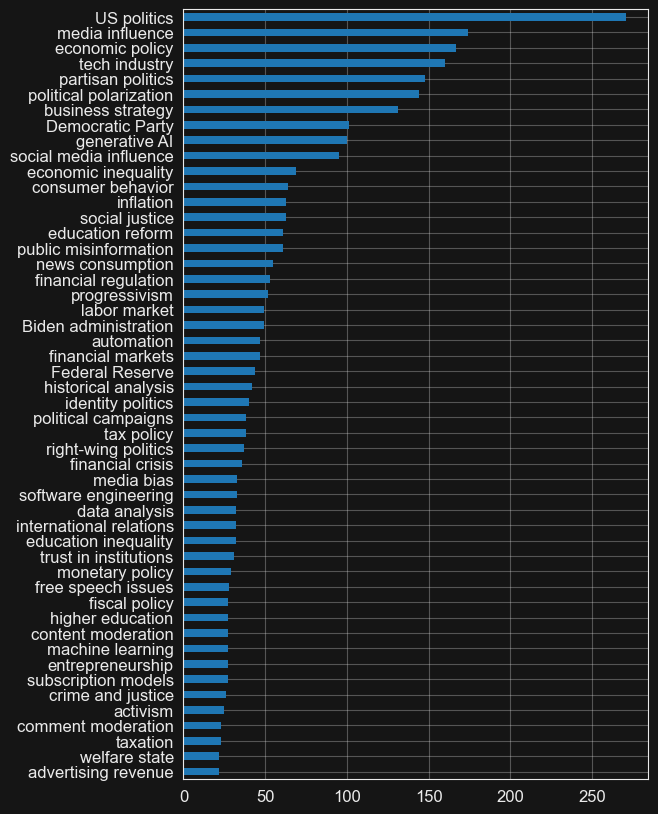

In [71]:
defined_tag_counts_in_given = defined_tag_counts[defined_tag_counts.index.isin(tag_definitions['tag'])]
defined_tag_counts_in_given.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

<Axes: >

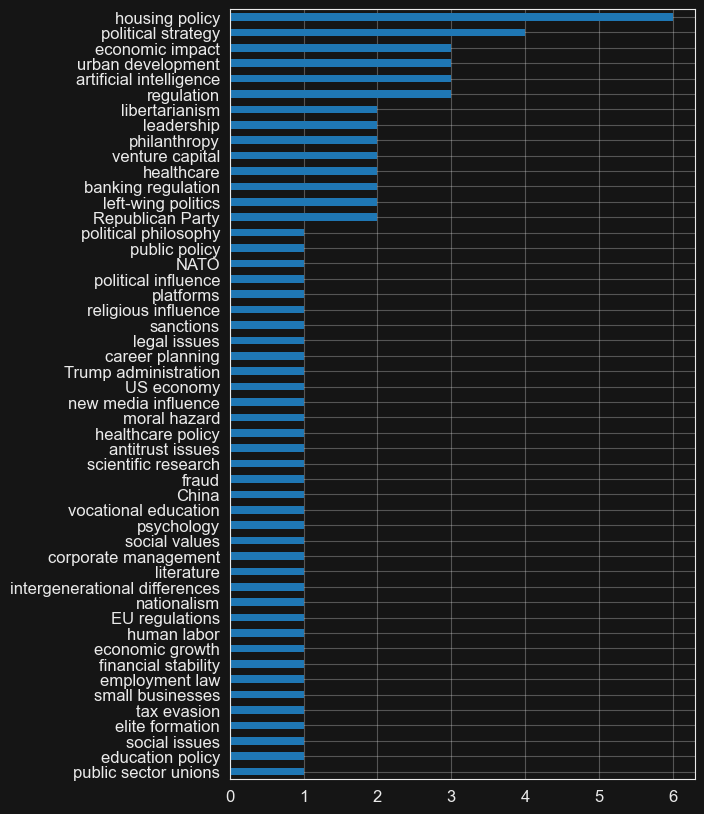

In [72]:
defined_tag_counts_not_in_given = defined_tag_counts[~defined_tag_counts.index.isin(tag_definitions['tag'])]
defined_tag_counts_not_in_given.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

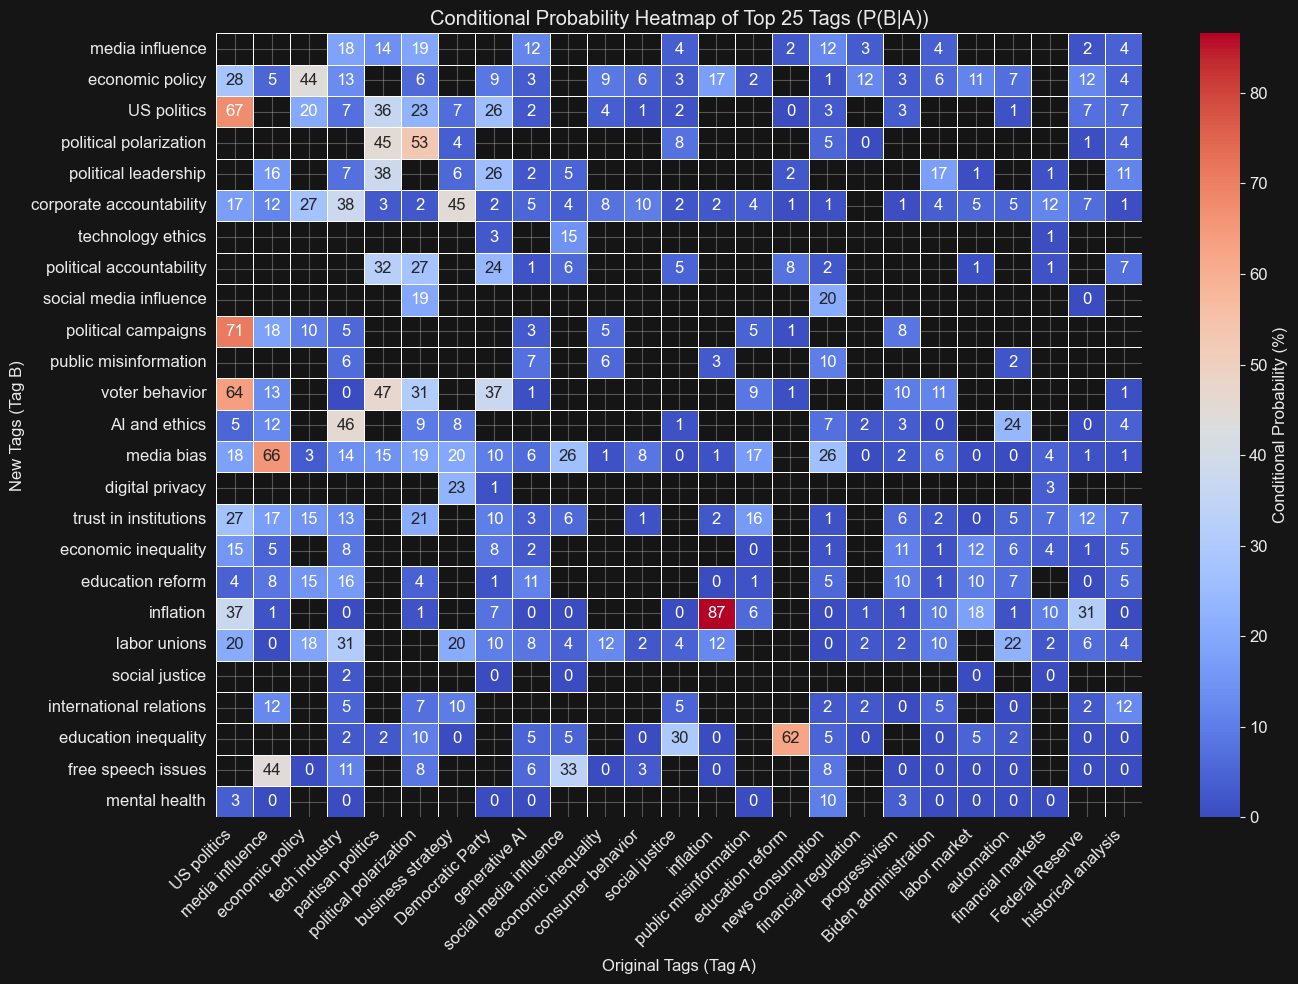

In [73]:
# Step 1: Flatten the tags into DataFrames
selected_flat = pd.DataFrame(
    [(id_, tag) for id_, tags in selected_tags_comments['tags'].items() for tag in tags],
    columns=['id', 'tag']
)
defined_tags_set = set(tag_definitions['tag'])
defined_flat = pd.DataFrame(
    [(id_, tag) for id_, tags in defined_tags_comments['tags'].items()
     for tag in tags
     if tag in defined_tags_set],
    columns=['id', 'tag']
)

# Step 2: Get the top 25 tags for each group
top_selected_tags = selected_flat['tag'].value_counts().nlargest(25).index
top_defined_tags = defined_flat['tag'].value_counts().nlargest(25).index

# Step 3: Filter the DataFrames for only the top tags
selected_top = selected_flat[selected_flat['tag'].isin(top_selected_tags)]
defined_top = defined_flat[defined_flat['tag'].isin(top_defined_tags)]

# Step 4: Merge the two DataFrames on the "id" column
merged_tags = selected_top.merge(defined_top, on='id', suffixes=('_original', '_defined'), how='inner')

# Step 5: Create a co-occurrence matrix
cooccurrence_matrix = pd.crosstab(
    merged_tags['tag_original'], merged_tags['tag_defined']
)

# Step 6: Calculate the correct normalization denominator
# Group by original tags to count unique IDs per tag
denominator = selected_top.groupby('tag')['id'].nunique()

# Normalize the co-occurrence matrix using the correct denominator
conditional_prob_matrix = cooccurrence_matrix.div(denominator, axis=0)

# Step 7: Reorder rows and columns based on top tags frequency
conditional_prob_matrix = conditional_prob_matrix.loc[top_selected_tags, top_defined_tags]

# Step 8: Create a mask for cells with low counts (<5 occurrences)
mask = cooccurrence_matrix < 5

# Step 9: Create the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    conditional_prob_matrix * 100,  # Convert probabilities to percentages
    annot=True, fmt='.0f', cmap='coolwarm', linewidths=0.5, mask=mask, cbar_kws={'label': 'Conditional Probability (%)'}
)
plt.title('Conditional Probability Heatmap of Top 25 Tags (P(B|A))')
plt.xlabel('Original Tags (Tag A)')
plt.ylabel('New Tags (Tag B)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Display the heatmap
plt.show()

<Axes: ylabel='tag'>

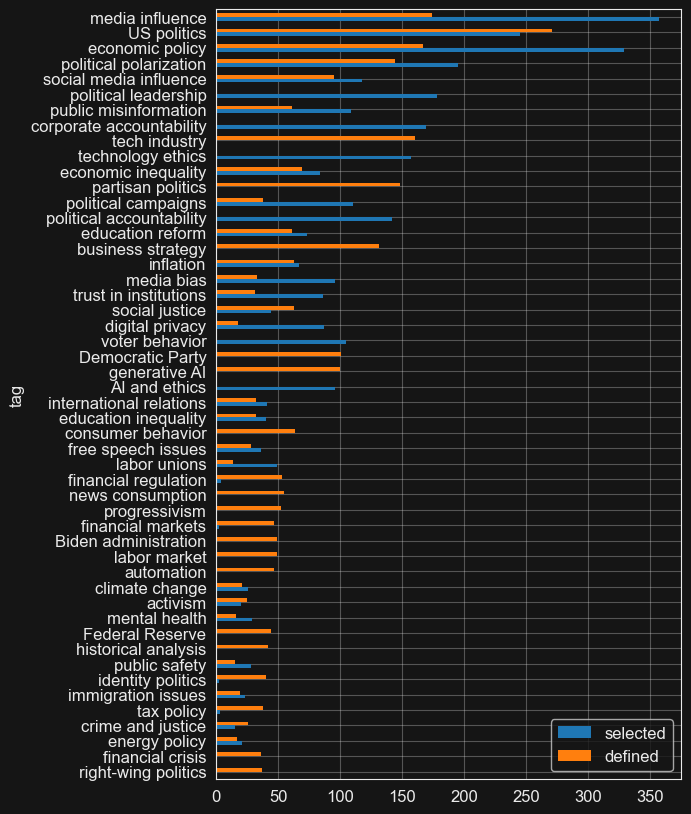

In [74]:
(pd.concat([
    selected_flat['tag'].value_counts(),
    defined_flat['tag'].value_counts(),
], axis=1, keys=['selected', 'defined'])
 .fillna(0).astype(int)
 .assign(total=lambda df: df['selected'] + df['defined'])
 .sort_values('total', ascending=False)
 .head(50)
 .drop(['total'], axis=1)
 .iloc[::-1]
 .plot.barh(figsize=(6, 10))
 )

In [75]:
selected_flat['tag'].value_counts()

tag
media influence              357
economic policy              329
US politics                  245
political polarization       195
political leadership         178
                            ... 
unionization                   1
public employment              1
government accountability      1
automation                     1
online discourse               1
Name: count, Length: 190, dtype: int64

In [76]:
def select_sort_tags(tags: list[str]) -> list[str]:
    return sorted(tag for tag in tags if tag in defined_tags_set)


with COMMENT_TAGS_PATH.open('w') as f:
    json.dump(dict(defined_tags_comments['tags'].map(select_sort_tags).sort_index().items()), f, indent=2)

In [32]:
defined_tag_counts.head(5)

US politics          250
media influence      158
economic policy      148
tech industry        146
partisan politics    138
Name: count, dtype: int64

In [33]:
tag = defined_tag_counts.index[0]
tag_definition, = tag_definitions[tag_definitions["tag"] == tag]["definition"]
print(f'{tag=}: {tag_definition=}')
tag_comments = best_comments[
    best_comments.index.isin(defined_tags_comments[defined_tags_comments['tags'].map(lambda tags: tag in tags)].index)]
print(f'{len(tag_comments)=}')
top_tag_comments = tag_comments.sort_values('likes', ascending=False).head(100)
print(f'{len(top_tag_comments)=}')
tag_comments_formatted = '\n\n'.join(
    f'Comment {i}:\n{body}'
    for i, body in enumerate(top_tag_comments['body'], 1)
)
# print(tag_comments_formatted)
print(f'{openai_util.count_tokens(tag_comments_formatted)=}')

tag='US politics': tag_definition='The political activities, events, and policies related to the governance of the United States.'
len(tag_comments)=250
len(top_tag_comments)=100
openai_util.count_tokens(tag_comments_formatted)=23511


In [34]:
summarize_tagged_comments_response = PROMPT_CACHE.get_or_create(
    prompt_rel_path=Path('summarize_tagged_comments/v0.txt'),
    cache_key=f'hagy_{tag}',
    template_values=dict(tag=tag, definition=tag_definition, comments=tag_comments_formatted),
    cache_suffix='md'
)

- **Understanding US Political Dynamics**: 
  - The Trump era brought significant changes, often attributed to misinformation, but it's argued that deeper ideological divides exist that are not solely misinformation-based.
  - Democrats face challenges in appealing to moderates, balancing progressive and moderate stances, and managing intra-party contradictions.
  - There is a critique of political strategies that prioritize morality and ideological purity over pragmatism, leading to polarized political landscapes.
  
- **Role of Key Political Figures**:
  - Trump is scrutinized for his unique, disruptive leadership style, and his impact on the political and media environments continues to be significant.
  - Figures like Musk, Soros, and Thiel are noted for their influence on politics through financial means, each reflecting broader political movements they support.

- **Gun Control and Judicial Politics**:
  - There is a complex discussion around gun control, with contradictions in t

In [35]:
display(Markdown(summarize_tagged_comments_response))

- **Understanding US Political Dynamics**: 
  - The Trump era brought significant changes, often attributed to misinformation, but it's argued that deeper ideological divides exist that are not solely misinformation-based.
  - Democrats face challenges in appealing to moderates, balancing progressive and moderate stances, and managing intra-party contradictions.
  - There is a critique of political strategies that prioritize morality and ideological purity over pragmatism, leading to polarized political landscapes.
  
- **Role of Key Political Figures**:
  - Trump is scrutinized for his unique, disruptive leadership style, and his impact on the political and media environments continues to be significant.
  - Figures like Musk, Soros, and Thiel are noted for their influence on politics through financial means, each reflecting broader political movements they support.

- **Gun Control and Judicial Politics**:
  - There is a complex discussion around gun control, with contradictions in the policies advocated by different sides, illustrating the broader national challenge.
  - The Supreme Court's decisions on major issues like gun control and student debts influence the national political discourse, often polarizing opinions further.

- **Media Influence**:
  - Criticism persists regarding media platforms and their role in shaping narratives, with discussions about bias and responsibility in media coverage.
  - Social media's role in democratizing political discourse yet complicating cohesive political platforms is acknowledged as a modern challenge.

- **Governance and Policy**:
  - US governance is perceived as hampered by polarization and a lack of strategic compromise, particularly in addressing bipartisan policy challenges such as fiscal austerity and tax reforms.
  - There is a call for better strategic alignment within parties to advance coherent, electorally viable agendas that address both base and broader electorate concerns.

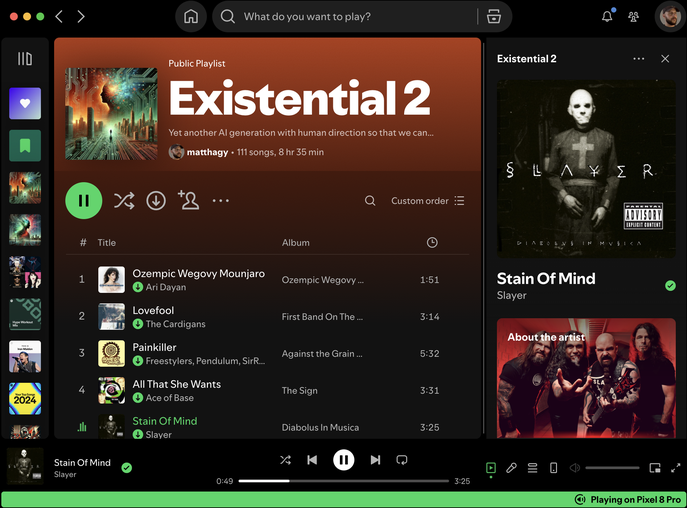

In [78]:
from IPython.display import display
from PIL import Image
from pathlib import Path
import io

img_path = Path("~/Downloads/wip-music.png").expanduser()
img = Image.open(img_path)

scale = 0.33
new_size = (int(scale * img.width), int(scale * img.height))
img_resized = img.resize(new_size, Image.LANCZOS)

buffer = io.BytesIO()
img_resized.save(buffer, format="PNG", optimize=True, compress_level=9)
img_low_res = Image.open(buffer)

display(img_low_res)

In [79]:
img_low_res.save('/tmp/tmp.png')